In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
!pip install pytrials

import requests
import json
from pytrials.client import ClinicalTrials
import os
import re
from requests.exceptions import ChunkedEncodingError, ConnectionError, Timeout
import time
from tqdm import tqdm
import ast

In [3]:
path_reactions = '/content/drive/My Drive/CSV/reactions.csv'
path_reports = '/content/drive/My Drive/CSV/reports.csv'
path_drugs_alternates = '/content/drive/My Drive/CSV/drugs_alternates.csv'
df_reactions = pd.read_csv(path_reactions)
df_reports = pd.read_csv(path_reports)
df_drugs_alternates = pd.read_csv(path_drugs_alternates)

In [ ]:
# load all data with alternate drug names
path_acute_myocardial_infarction = '/content/drive/My Drive/CSV/Altdrug/Myocardial_infarction_altdrug.csv'
path_heart_failure = '/content/drive/My Drive/CSV/Altdrug/Heart_failure_altdrug.csv'
path_hypertension = '/content/drive/My Drive/CSV/Altdrug/hypertension_altdrug.csv'
path_ischemic_heart_disease = '/content/drive/My Drive/CSV/Altdrug/ischemic_heart_disease_altdrug.csv'
path_stroke = '/content/drive/My Drive/CSV/Altdrug/stroke_altdrug.csv'
path_COPD = '/content/drive/My Drive/CSV/Altdrug/COPD_altdrug.csv'
path_diabetes = '/content/drive/My Drive/CSV/Altdrug/diabetes_altdrug.csv'
path_asthma = '/content/drive/My Drive/CSV/Altdrug/asthma_altdrug.csv'
path_dementia = '/content/drive/My Drive/CSV/Altdrug/dementia_altdrug.csv'
path_schizophrenia = '/content/drive/My Drive/CSV/Altdrug/schizophrenia_altdrug.csv'
path_epilepsy = '/content/drive/My Drive/CSV/Altdrug/epilepsy_altdrug.csv'
path_multiple_sclerosis = '/content/drive/My Drive/CSV/Altdrug/multiple_sclerosis_altdrug.csv'
path_parkinsonism = '/content/drive/My Drive/CSV/Altdrug/parkinsonism_altdrug.csv'

df_acute_myocardial_infarction = pd.read_csv(path_acute_myocardial_infarction)
df_heart_failure = pd.read_csv(path_heart_failure)
df_hypertension = pd.read_csv(path_hypertension)
df_ischemic_heart_disease = pd.read_csv(path_ischemic_heart_disease)
df_stroke = pd.read_csv(path_stroke)
df_COPD = pd.read_csv(path_COPD)
df_diabetes = pd.read_csv(path_diabetes)
df_asthma = pd.read_csv(path_asthma)
df_dementia = pd.read_csv(path_dementia)
df_schizophrenia = pd.read_csv(path_schizophrenia)
df_epilepsy = pd.read_csv(path_epilepsy)
df_multiple_sclerosis = pd.read_csv(path_multiple_sclerosis)
df_parkinsonism = pd.read_csv(path_parkinsonism)

diseases = {"Myocardial infarction": df_acute_myocardial_infarction,
               "Heart failure":df_heart_failure,
               "Hypertension": df_hypertension,
               "Ischemic heart disease": df_ischemic_heart_disease,
               "Stroke": df_stroke,
               "Chronic obstructive pulmonary disease": df_COPD,
                "Diabetes": df_diabetes,
                "Asthma": df_asthma,
                "Dementia": df_dementia,
                "Schizophrenia": df_schizophrenia,
                "Epilepsy": df_epilepsy,
                "Multiple sclerosis": df_multiple_sclerosis,
                "Parkinson's": df_parkinsonism
              }

In [4]:
acute_myocardial_infarction = ["Acute myocardial infarction","Myocardial infarction"]
heart_failure = ["Left ventricular failure", "Cardiac failure congestive", "Cardiac failure chronic", "Cardiac failure", "Right ventricular failure"]
hypertension = ["Hypertension", "Blood pressure management", "Blood pressure abnormal", "HIGH BLOOD PRESSURE MEDS", "Blood pressure increased"]
ischemic_heart_disease = ["Myocardial ischaemia", "Ischaemic heart disease prophylaxis", "Ischaemic cardiomyopathy", "Coronary artery disease", "Arteriosclerosis coronary artery"]
stroke = ["Transient ischaemic attack","Ischaemic stroke","Haemorrhagic stroke","Middle cerebral artery stroke","Embolic stroke","Lacunar stroke","Thrombotic stroke"]
chronic_obstructive_pulmonary = ["Chronic obstructive pulmonary disease", "Obstructive airways disorder", "Infective exacerbation of chronic obstructive airways", "Emphysema", "Chronic respiratory disease"]
diabetes = ["Type 2 diabetes mellitus", "Type 1 diabetes mellitus", "Diabetes mellitus", "Diabetes", "diabetes"]
asthma = ["Asthma", "asthma", "Active Asthma", "Active Asthma"]
dementia = ["Dementia Alzheimer's type", 'Dementia', 'Dementia with Lewy bodies', 'Frontotemporal dementia']
schizophrenia = ["Schizophrenia"]
epilepsy = ["epilepsy", "Epilepsy", "EPILEPSY"]
multiple_sclerosis =  ["Relapsing-remitting multiple sclerosis", 'Multiple sclerosis', 'Secondary progressive multiple sclerosis', 'Primary progressive multiple sclerosis']
parkinsonism = ['Parkinsonian rest tremor', "Parkinson's disease", 'Parkinsonism']

diseases = {"Myocardial infarction": acute_myocardial_infarction,
            "Heart failure":heart_failure,
            "Hypertension": hypertension,
            "Ischemic heart disease": ischemic_heart_disease,
            "Stroke": stroke,
            "Chronic obstructive pulmonary disease": chronic_obstructive_pulmonary,
            "Diabetes": diabetes,
            "Asthma": asthma,
            "Dementia": dementia,
            "Schizophrenia": schizophrenia,
            "Epilepsy": epilepsy,
            "Multiple sclerosis": multiple_sclerosis,
            "Parkinson's": parkinsonism
              }

In [6]:


data = []

def get_top_effects(df):
  side_effects = df['PT_NAME_ENG'].value_counts().head(5)
  top_5 = side_effects.index.tolist()
  return top_5


for item in diseases.items():

  # indicate the disease name
  disease = item[0]
  df = df_drugs_alternates[df_drugs_alternates['INDICATION_NAME_ENG'].isin(item[1])]
  df_merged = pd.merge(df_reports, df, on='REPORT_ID', how='inner')
  df_merged = pd.merge(df_merged, df_reactions, on='REPORT_ID', how='inner')
  df_merged["INDICATION_NAME_ENG"] = df_merged["INDICATION_NAME_ENG"].str.upper()

  # find all drug - disease pairs
  for drug in df_merged['ALTERNATE DRUG'].unique():
    if isinstance(drug, str) and len(drug.strip()) > 0:
      df_filtered  = df_merged[df_merged['ALTERNATE DRUG'] == drug]
      df_female = df_filtered[df_filtered['GENDER_ENG'] == 'Female']
      side_effects_female = get_top_effects(df_female)
      df_male = df_filtered[df_filtered['GENDER_ENG'] == 'Male']
      side_effects_male = get_top_effects(df_male)
      total_women = df_filtered[df_filtered['GENDER_ENG'] == 'Female'].shape[0]
      serious_women_count = df_filtered[(df_filtered['GENDER_ENG'] == 'Female') & (df_filtered['SERIOUSNESS_ENG'] == 'Serious')].shape[0]
      # get proportions
      if total_women > 0:
          percentage_serious_women = round((serious_women_count / total_women) * 100, 2)
      else:
          percentage_serious_women = -1.00

      total_men = df_filtered[df_filtered['GENDER_ENG'] == 'Male'].shape[0]
      serious_men_count = df_filtered[(df_filtered['GENDER_ENG'] == 'Male') & (df_filtered['SERIOUSNESS_ENG'] == 'Serious')].shape[0]
      if total_men > 0:
          percentage_serious_men = round((serious_men_count / total_men) * 100,2)
      else:
        percentage_serious_men = -1.00

      if total_women + total_men > 0:
        percent_women = round(total_women / (total_women + total_men) * 100,2)
        percent_men = round(total_men / (total_women + total_men) * 100,2)

      if total_women + total_men > 10:
        # append data to new dataframe if number of reports higher than 10
        data.append({
            'Drug': drug,
            'Indication': disease.upper(),
            'Total Female Reports': total_women,
            'Total Male Reports': total_men,
            'Percentage Female Reports': percent_women,
            'Percentage Male Reports': percent_men,
            'Percentage Serious Female Reports': percentage_serious_women,
            'Percentage Serious Male Reports': percentage_serious_men,
            'Top 5 Side Effects Female': side_effects_female,
            'Top 5 Side Effects Male': side_effects_male
      })

df_data = pd.DataFrame(data)
pd.set_option('display.width', 500)
print(df_data)

# Specify the directory where you want to save the CSV file
# You can set this to any valid path where you have write permissions
save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file
csv_file_path = os.path.join(save_directory, 'disease_pair.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
df_data.to_csv(csv_file_path, index=False)
print(f'Results have been exported to {csv_file_path}')

                Drug             Indication  Total Female Reports  Total Male Reports  Percentage Female Reports  Percentage Male Reports  Percentage Serious Female Reports  Percentage Serious Male Reports                          Top 5 Side Effects Female                            Top 5 Side Effects Male
0        CLOPIDOGREL  MYOCARDIAL INFARCTION                   178                 318                      35.89                    64.11                              96.63                            88.05  [Spinal epidural haematoma, Diarrhoea, Myalgia...  [Off label use, Drug ineffective, Pruritus, My...
1            HEPARIN  MYOCARDIAL INFARCTION                    32                  33                      49.23                    50.77                             100.00                            96.97  [Haemoglobin decreased, Cerebral haemorrhage, ...  [Haemoglobin decreased, Heparin-induced thromb...
2         METOPROLOL  MYOCARDIAL INFARCTION                    48           

In [7]:
path_acute_myocardial_infarction_pairs = '/content/drive/My Drive/CSV/drug_myocardial_infarction_pair.csv'
path_heart_failure_pairs = '/content/drive/My Drive/CSV/drug_heart_failure_pair.csv'
path_hypertension_pairs = '/content/drive/My Drive/CSV/drug_hypertension_pair.csv'
path_ischemic_heart_disease_pairs = '/content/drive/My Drive/CSV/drug_ischemic_heart_disease_pair.csv'
path_stroke_pairs = '/content/drive/My Drive/CSV/drug_stroke_pair.csv'
path_COPD_pairs = '/content/drive/My Drive/CSV/drug_COPD_pair.csv'
path_diabetes_pairs = '/content/drive/My Drive/CSV/drug_diabetes_pair.csv'
path_asthma_pairs = '/content/drive/My Drive/CSV/drug_asthma_pair.csv'
path_dementia_pairs = '/content/drive/My Drive/CSV/drug_dementia_pair.csv'
path_schizophrenia_pairs = '/content/drive/My Drive/CSV/drug_schizophrenia_pair.csv'
path_epilepsy_pairs = '/content/drive/My Drive/CSV/drug_epilepsy_pair.csv'
path_multiple_sclerosis_pairs = '/content/drive/My Drive/CSV/drug_multiple_sclerosis_pair.csv'
path_parkinsonism_pairs = '/content/drive/My Drive/CSV/drug_parkinsonism_pair.csv'

df_acute_myocardial_infarction_pairs = pd.read_csv(path_acute_myocardial_infarction_pairs)
df_heart_failure_pairs = pd.read_csv(path_heart_failure_pairs)
df_hypertension_pairs = pd.read_csv(path_hypertension_pairs)
df_ischemic_heart_disease_pairs = pd.read_csv(path_ischemic_heart_disease_pairs)
df_stroke_pairs = pd.read_csv(path_stroke_pairs)
df_COPD_pairs = pd.read_csv(path_COPD_pairs)
df_diabetes_pairs = pd.read_csv(path_diabetes_pairs)
df_asthma_pairs = pd.read_csv(path_asthma_pairs)
df_dementia_pairs = pd.read_csv(path_dementia_pairs)
df_schizophrenia_pairs = pd.read_csv(path_schizophrenia_pairs)
df_epilepsy_pairs = pd.read_csv(path_epilepsy_pairs)
df_multiple_sclerosis_pairs = pd.read_csv(path_multiple_sclerosis_pairs)
df_parkinsonism_pairs = pd.read_csv(path_parkinsonism_pairs)

df_drug_disease = pd.read_csv('/content/drive/My Drive/CSV/disease_pair.csv')


In [8]:
ctg_studies_path = '/content/drive/My Drive/Data_MedEffect/ctg-studies.csv'
ctg_studies = pd.read_csv(ctg_studies_path)
ctg_studies["Conditions"] = ctg_studies["Conditions"].str.upper()
ctg_studies["Interventions"] = ctg_studies["Interventions"].str.upper()

ctg_studies["Conditions"] = ctg_studies["Conditions"].fillna('').astype(str)
ctg_studies["Interventions"] = ctg_studies["Interventions"].fillna('').astype(str)

In [9]:
 # get study ids related to each drug and disease as the search
def get_study_ids(drug, disease, df):
    # Filter rows based on drug
    # drug_mask = df["Interventions"].str.contains(drug, case=False, na=False)
    # # Filter rows based on disease
    # disease_mask = df["Conditions"].str.contains(disease, case=False, na=False)
    drug_regex = re.compile(re.escape(drug.strip()), re.IGNORECASE)
    disease_regex = re.compile(re.escape(disease.strip()), re.IGNORECASE)

    # Filter rows based on drug using regex
    drug_mask = df["Interventions"].apply(lambda x: bool(drug_regex.search(str(x))) if pd.notna(x) else False)
    # Filter rows based on disease using regex
    disease_mask = df["Conditions"].apply(lambda x: bool(disease_regex.search(str(x))) if pd.notna(x) else False)
    # Combine both masks
    combined_mask = drug_mask & disease_mask
    # Get study IDs for the filtered rows
    return df[combined_mask]['NCT Number'].tolist()

tqdm.pandas()
curr_df = df_drug_disease
#change df names here
curr_df['NCT Numbers'] = curr_df.progress_apply(lambda row: get_study_ids(row['Drug'], row['Indication'], ctg_studies), axis=1)
print(curr_df)
save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file, CHANGE SAVE NAME
csv_file_path = os.path.join(save_directory, 'drug_disease_pair_studies.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
curr_df.to_csv(csv_file_path, index=False)
print(f'Results have been exported to {csv_file_path}')


100%|██████████| 843/843 [27:38<00:00,  1.97s/it]


                Drug             Indication  Total Female Reports  Total Male Reports  Percentage Female Reports  Percentage Male Reports  Percentage Serious Female Reports  Percentage Serious Male Reports                          Top 5 Side Effects Female                            Top 5 Side Effects Male                                        NCT Numbers
0        CLOPIDOGREL  MYOCARDIAL INFARCTION                   178                 318                      35.89                    64.11                              96.63                            88.05  ['Spinal epidural haematoma', 'Diarrhoea', 'My...  ['Off label use', 'Drug ineffective', 'Pruritu...  [NCT02233790, NCT00684203, NCT00623623, NCT046...
1            HEPARIN  MYOCARDIAL INFARCTION                    32                  33                      49.23                    50.77                             100.00                            96.97  ['Haemoglobin decreased', 'Cerebral haemorrhag...  ['Haemoglobin decreased'

In [ ]:
# concatenate all files together
file_names = ['drug_myocardial_infarction_pair_studies.csv',
              'drug_heart_failure_pair_studies.csv',
              'drug_hypertension_pair_studies.csv',
              'drug_ischemic_heart_disease_pair_studies.csv',
              'drug_stroke_pair_studies.csv',
              'drug_COPD_pair_studies.csv',
              'drug_diabetes_pair_studies.csv',
              'drug_asthma_pair_studies.csv',
              'drug_dementia_pair_studies.csv',
              'drug_schizophrenia_pair_studies.csv',
              'drug_epilepsy_pair_studies.csv',
              'drug_multiple_sclerosis_pair_studies.csv',
              'drug_parkinsonism_pair_studies.csv'
              ]

save_directory = '/content/drive/My Drive/CSV'
output_file = os.path.join(save_directory, 'combined_drug_disease_studies.csv')

# List to store DataFrames
df_list = []

# Iterate over the list of filenames and read each CSV into a DataFrame
for file_name in file_names:
    file_path = os.path.join(save_directory, file_name)
    if os.path.exists(file_path):
        df_chunk = pd.read_csv(file_path)
        df_list.append(df_chunk)
        print(f"Processed {file_name}")
    else:
        print(f"File {file_name} does not exist in the directory {save_directory}")

# Concatenate all DataFrames in the list
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)

    # Save the combined DataFrame to a single CSV file
    combined_df.to_csv(output_file, index=False)
    print(f"All files combined and saved to {output_file}")
else:
    print("No files were found to combine.")

Processed drug_myocardial_infarction_pair_studies.csv
Processed drug_heart_failure_pair_studies.csv
Processed drug_hypertension_pair_studies.csv
Processed drug_ischemic_heart_disease_pair_studies.csv
Processed drug_stroke_pair_studies.csv
Processed drug_COPD_pair_studies.csv
Processed drug_diabetes_pair_studies.csv
Processed drug_asthma_pair_studies.csv
Processed drug_dementia_pair_studies.csv
Processed drug_schizophrenia_pair_studies.csv
Processed drug_epilepsy_pair_studies.csv
Processed drug_multiple_sclerosis_pair_studies.csv
Processed drug_parkinsonism_pair_studies.csv
All files combined and saved to /content/drive/My Drive/CSV/combined_drug_disease_studies.csv


In [11]:
# Initialize ClinicalTrials client
ct = ClinicalTrials()
api_url = 'https://clinicaltrials.gov/api/v2/studies/'

# get data associated with studies

path_combined_pairs = '/content/drive/My Drive/CSV/drug_disease_pair_studies.csv'
df_data = pd.read_csv(path_combined_pairs)
print(df_data)

def fetch_data_with_retries(url, max_retries=3, backoff_factor=0.3):
    for retry in range(max_retries):
        try:
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for HTTP errors
            return response.json()
        except (ChunkedEncodingError, ConnectionError, Timeout) as e:
            if retry < max_retries - 1:
                time.sleep(backoff_factor * (2 ** retry))  # Exponential backoff
            else:
                raise
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
            raise

df_data['Num Studies'] = pd.Series(dtype='int')
df_data['Total females in studies'] = pd.Series(dtype='int')
df_data['Total males in studies'] = pd.Series(dtype='int')
df_data['Female proportion in studies'] = pd.Series(dtype='float')
df_data['Male proportion in studies'] = pd.Series(dtype='float')

study_data = []
for index, row in df_data.iterrows():
    drug = row['Drug']
    indication = row['Indication']
    list_NCT = ast.literal_eval(row['NCT Numbers'])

    num_studies = len(list_NCT)
    df_data.at[index, 'Num Studies'] = int(num_studies)

    tot_num_females = 0
    tot_num_males = 0
    for study_id in list_NCT:
        try:
            female_count = 0
            male_count = 0
            file_path = f"/content/drive/My Drive/StudyResults/{study_id}.json"
            if os.path.exists(file_path):
              with open(file_path, 'r') as json_file:
                data = json.load(json_file)
            else:
              data = fetch_data_with_retries(api_url + study_id)

              if data.get("hasResults", False):
                  # Initialize counters for female and male participants
                  file_save_dir = "/content/drive/My Drive/StudyResults"
                  study_path = os.path.join(file_save_dir, f"{study_id}.json")
                  with open(study_path, 'w') as json_file:
                      json.dump(data, json_file)


            # Parse the JSON data to count the participants
            if "resultsSection" in data and "baselineCharacteristicsModule" in data["resultsSection"]:
              for measure in data["resultsSection"]["baselineCharacteristicsModule"]["measures"]:
                  if measure["title"] == "Sex: Female, Male":
                      for category in measure["classes"][0]["categories"]:
                          if category["title"] == "Female":
                              female_values = []
                              if "measurements" in category:
                                  for measurement in category["measurements"]:
                                      if measurement["value"].replace('.', '', 1).isdigit():
                                          female_values.append(int(float(measurement["value"])))
                              female_count = sum(female_values)
                          elif category["title"] == "Male":
                              male_values = []
                              if "measurements" in category:
                                  for measurement in category["measurements"]:
                                      if measurement["value"].replace('.', '', 1).isdigit():
                                          male_values.append(int(float(measurement["value"])))
                              male_count = sum(male_values)
              study_data.append({
                  'Study NCT': study_id,
                  'Number of participants': female_count + male_count,
                  'Number of female participants': female_count,
                  'Number of male participants': male_count
              })
              tot_num_females += female_count
              tot_num_males += male_count
        except Exception as e:
            print(f"Failed to fetch data for study ID {study_id}: {e}")

    total_num_participants = tot_num_females + tot_num_males
    if total_num_participants > 0:
        # Calculate proportions
        female_proportion = round((tot_num_females / total_num_participants) * 100, 2)
        male_proportion = round((tot_num_males / total_num_participants) * 100, 2)
    else:
        female_proportion = -1.00
        male_proportion = -1.00

    # Update DataFrame
    df_data.at[index, 'Total females in studies'] = int(tot_num_females)
    df_data.at[index, 'Total males in studies'] = int(tot_num_males)
    df_data.at[index, 'Female proportion in studies'] = female_proportion
    df_data.at[index, 'Male proportion in studies'] = male_proportion

df_data = df_data[df_data["Num Studies"]>= 3]
df_data = df_data[(df_data["Total females in studies"] + df_data["Total males in studies"]) >= 20]
print(df_data)

save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file
csv_file_path = os.path.join(save_directory, 'combined_study_results.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
df_data.to_csv(csv_file_path, index=False)

df_study_data = pd.DataFrame(study_data)
df_study_data = df_study_data.drop_duplicates(subset=['Study NCT'], keep='first')
print(df_study_data)
study_data_path = os.path.join(save_directory, 'study_data.csv')
df_study_data.to_csv(study_data_path, index=False)

                Drug             Indication  Total Female Reports  Total Male Reports  Percentage Female Reports  Percentage Male Reports  Percentage Serious Female Reports  Percentage Serious Male Reports                          Top 5 Side Effects Female                            Top 5 Side Effects Male                                        NCT Numbers
0        CLOPIDOGREL  MYOCARDIAL INFARCTION                   178                 318                      35.89                    64.11                              96.63                            88.05  ['Spinal epidural haematoma', 'Diarrhoea', 'My...  ['Off label use', 'Drug ineffective', 'Pruritu...  ['NCT02233790', 'NCT00684203', 'NCT00623623', ...
1            HEPARIN  MYOCARDIAL INFARCTION                    32                  33                      49.23                    50.77                             100.00                            96.97  ['Haemoglobin decreased', 'Cerebral haemorrhag...  ['Haemoglobin decreased'

In [12]:
path_combined = '/content/drive/My Drive/CSV/combined_study_results.csv'
combined_df = pd.read_csv(path_combined)
path_study_df = '/content/drive/My Drive/CSV/study_data.csv'
df_study_data = pd.read_csv(path_study_df)

# sort the studies in order of importance, by number of participants, return top 3 studies for each drug disease pair
def sort(studies_list, studies_data):
  studies_list = ast.literal_eval(studies_list)
  df_sorted = df_study_data[df_study_data['Study NCT'].isin(studies_list)]
  print(df_sorted)
  df_sorted = df_sorted.sort_values(by='Number of participants', ascending=False)
  print(df_sorted)
  top_3 = df_sorted.head(3)['Study NCT'].tolist()
  sum_females =  df_sorted.head(3)['Number of female participants'].sum()
  total_females = df_sorted['Number of female participants'].sum()
  print(total_females)
  total_males = df_sorted['Number of male participants'].sum()
  print(total_males)
  sum_males = df_sorted.head(3)['Number of male participants'].sum()
  total_participants = df_sorted.head(3)['Number of participants'].sum()
  if total_participants > 0:
    female_proportion = sum_females/total_participants * 100
    male_proportion = sum_males/total_participants * 100
  else:
    female_proportion = -1.00
    male_proportion = -1.00

  return (top_3, total_participants, sum_females, sum_males, female_proportion, male_proportion)

tqdm.pandas()
result = combined_df['NCT Numbers'].progress_apply(lambda x: sort(x, df_study_data))

# Assign the results to new columns in combined_df
combined_df[[
    "Most relevant studies",
    'Number of participants in most relevant studies',
    'Number of female participants in most relevant studies',
    'Number of male participants in most relevant studies',
    'Proportion of females in most relevant studies',
    'Proportion of males in most relevant studies'
]] = pd.DataFrame(result.tolist(), index=combined_df.index)

save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file
csv_file_path = os.path.join(save_directory, 'combined_study_results_top_3.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
combined_df.to_csv(csv_file_path, index=False)


 11%|█         | 33/302 [00:00<00:01, 149.73it/s]

      Study NCT  Number of participants  Number of female participants  Number of male participants
0   NCT00684203                     234                             58                          176
1   NCT00623623                    3794                            806                         2988
2   NCT02224274                      72                             12                           60
3   NCT01586975                     186                            102                           84
4   NCT03161678                     178                             90                           88
5   NCT02931045                     120                             28                           92
6   NCT01235351                     666                            168                          498
7   NCT03207451                     162                             46                          116
8   NCT02548650                     128                             36                           92


 16%|█▌        | 48/302 [00:00<00:01, 147.92it/s]

       Study NCT  Number of participants  Number of female participants  Number of male participants
111  NCT00233480                      52                             20                           32
112  NCT00585611                       0                              0                            0
113  NCT02943590                     600                            284                          316
       Study NCT  Number of participants  Number of female participants  Number of male participants
113  NCT02943590                     600                            284                          316
111  NCT00233480                      52                             20                           32
112  NCT00585611                       0                              0                            0
304
348
      Study NCT  Number of participants  Number of female participants  Number of male participants
65  NCT02970669                     280                             64              

 25%|██▌       | 77/302 [00:00<00:01, 118.38it/s]

       Study NCT  Number of participants  Number of female participants  Number of male participants
393  NCT00949884                    1882                            856                         1026
318  NCT00739674                    1726                            894                          832
323  NCT00546052                    1714                            734                          980
202  NCT00546754                    1578                            754                          824
211  NCT00882440                    1152                            386                          766
394  NCT00673790                    1074                            472                          602
180  NCT00931710                     976                            426                          550
398  NCT00922480                     970                            300                          670
399  NCT00219141                     920                            224                    

 39%|███▊      | 117/302 [00:00<00:01, 121.71it/s]

       Study NCT  Number of participants  Number of female participants  Number of male participants
543  NCT01908699                     542                            394                          148
542  NCT00689819                     246                            160                           86
551  NCT01416636                     210                             98                          112
358  NCT01395329                      84                             32                           52
550  NCT00989963                      72                             60                           12
541  NCT00995566                      54                             41                           13
537  NCT03015402                      48                             28                           20
553  NCT04415333                      40                             22                           18
548  NCT01445873                      36                             29                    

 47%|████▋     | 143/302 [00:01<00:01, 117.13it/s]

       Study NCT  Number of participants  Number of female participants  Number of male participants
749  NCT00393458                    3456                            700                         2756
739  NCT01437397                    3338                           1564                         1774
666  NCT02796677                    3166                           1240                         1926
690  NCT01069289                    2586                            286                         2300
689  NCT00419744                    2436                            926                         1510
719  NCT00383721                    2392                            592                         1800
740  NCT03162055                    2208                            604                         1604
720  NCT00383435                    2110                            474                         1636
633  NCT01574651                    1868                            638                    

 55%|█████▌    | 167/302 [00:01<00:01, 115.39it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
1517  NCT02586155                    4836                           1236                         3600
1561  NCT02662569                    1972                           1128                          844
1519  NCT00862251                    1616                            772                          844
1560  NCT00309751                     824                            358                          466
1518  NCT00296374                     706                            216                          490
1564  NCT00344370                     428                            196                          232
1223  NCT01477853                     332                            150                          182
1562  NCT01236365                      84                             40                           44
1558  NCT00529191                      80                             40          

 64%|██████▎   | 192/302 [00:01<00:00, 114.81it/s]

       Study NCT  Number of participants  Number of female participants  Number of male participants
219  NCT01066039                     202                             92                          110
       Study NCT  Number of participants  Number of female participants  Number of male participants
219  NCT01066039                     202                             92                          110
92
110
        Study NCT  Number of participants  Number of female participants  Number of male participants
813   NCT02168491                       9                              3                            6
817   NCT02058160                    1472                            784                          688
843   NCT01476475                       0                              0                            0
859   NCT02058147                    2340                           1156                         1184
862   NCT02787551                    1028                            488       

 72%|███████▏  | 218/302 [00:01<00:00, 118.73it/s]

262
363
        Study NCT  Number of participants  Number of female participants  Number of male participants
1950  NCT01696214                      38                             20                           18
        Study NCT  Number of participants  Number of female participants  Number of male participants
1950  NCT01696214                      38                             20                           18
20
18
        Study NCT  Number of participants  Number of female participants  Number of male participants
1902  NCT02495168                    2282                           1322                          960
1914  NCT02446418                     840                            538                          302
1919  NCT03015259                    2878                           1808                         1070
1931  NCT00702325                     602                            392                          210
1933  NCT02062463                     970                           

 81%|████████  | 245/302 [00:02<00:00, 118.82it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
2389  NCT00206102                    2196                            904                         1292
2399  NCT00216476                    1332                            560                          772
2456  NCT01810380                     928                            400                          528
2417  NCT01157351                     888                            122                          766
2458  NCT00882518                     768                            404                          364
2365  NCT00330863                     610                            174                          436
2454  NCT00789698                     584                            194                          390
2401  NCT03557931                     466                            140                          326
2393  NCT00044655                     438                            146          

 90%|█████████ | 272/302 [00:02<00:00, 122.88it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
2600  NCT01954121                     866                            400                          466
2604  NCT00438451                     718                            288                          430
2607  NCT02707965                      40                             36                            4
2608  NCT00612235                     160                            160                            0
2613  NCT00855738                     111                             52                           59
2617  NCT03940326                     206                             98                          108
2620  NCT01229735                     686                            270                          416
2624  NCT02201251                     126                             68                           58
2632  NCT01891890                     144                             72          

100%|██████████| 302/302 [00:02<00:00, 119.36it/s]

        Study NCT  Number of participants  Number of female participants  Number of male participants
2779  NCT01412333                    1670                           1102                          568
2765  NCT01247324                    1642                           1084                          558
2910  NCT01194570                    1464                            722                          742
2914  NCT02861014                     680                            436                          244
2912  NCT02637856                     608                            438                          170
2911  NCT00676715                     436                            282                          154
2864  NCT02980042                     400                            286                          114
2909  NCT03606460                     282                            186                           96
2913  NCT04767698                       0                              0          

In [ ]:
pd.set_option('display.width', 500)
print(combined_df)
print(combined_df['NCT Numbers'][1])
sorted = sort(combined_df['NCT Numbers'][1], df_study_data)
print(sorted)

             Drug             Indication  Total Female Reports  Total Male Reports  Percentage Female Reports  Percentage Male Reports  Percentage Serious Female Reports  Percentage Serious Male Reports                          Top 5 Side Effects Female                            Top 5 Side Effects Male  ... Total females in studies  Total males in studies  Female proportion in studies  Male proportion in studies                    Most relevant studies  \
0     CLOPIDOGREL  MYOCARDIAL INFARCTION                   167                 294                      36.23                    63.77                              98.20                            88.78  ['Diarrhoea', 'Spinal epidural haematoma', 'My...  ['Off label use', 'Drug ineffective', 'Dyspnoe...  ...                  10918.0                 30130.0                         26.60                       73.40  [NCT00305162, NCT00257309, NCT00623623]   
1    TENECTEPLASE  MYOCARDIAL INFARCTION                    57                

In [13]:
path_acute_myocardial_infarction_CCDSS= '/content/drive/My Drive/CCDSS/acute_myocardial_infarction_CCDSS.csv'
path_heart_failure_CCDSS= '/content/drive/My Drive/CCDSS/heart_failure_CCDSS.csv'
path_hypertension_CCDSS= '/content/drive/My Drive/CCDSS/hypertension_CCDSS.csv'
path_ischemic_heart_disease_CCDSS= '/content/drive/My Drive/CCDSS/ischemic_heart_disease_CCDSS.csv'
path_stroke_CCDSS= '/content/drive/My Drive/CCDSS/stroke_CCDSS.csv'
path_COPD_CCDSS = '/content/drive/My Drive/CCDSS/chronic_obstructive_pulmonary_CCDSS.csv'
path_diabetes_CCDSS = '/content/drive/My Drive/CCDSS/diabetes_CCDSS.csv'
path_asthma_CCDSS ='/content/drive/My Drive/CCDSS/asthma_CCDSS.csv'
path_dementia_CCDSS = '/content/drive/My Drive/CCDSS/dementia_CCDSS.csv'
path_schizophrenia_CCDSS ='/content/drive/My Drive/CCDSS/schizophrenia_CCDSS.csv'
path_epilepsy_CCDSS = '/content/drive/My Drive/CCDSS/epilepsy_CCDSS.csv'
path_multiple_sclerosis_CCDSS = '/content/drive/My Drive/CCDSS/multiple_sclerosis_CCDSS.csv'
path_parkinsonism_CCDSS = '/content/drive/My Drive/CCDSS/parkinsonism_CCDSS.csv'

acute_myocardial_infarction_CCDSS = pd.read_csv(path_acute_myocardial_infarction_CCDSS, skiprows=1, encoding="latin1")
heart_failure_CCDSS = pd.read_csv(path_heart_failure_CCDSS, skiprows=1,encoding="latin1")
hypertension_CCDSS = pd.read_csv(path_hypertension_CCDSS,skiprows=1, encoding="latin1")
ischemic_heart_disease_CCDSS = pd.read_csv(path_ischemic_heart_disease_CCDSS,skiprows=1, encoding="latin1")
stroke_CCDSS = pd.read_csv(path_stroke_CCDSS, skiprows=1,encoding="latin1")
COPD_CCDSS = pd.read_csv(path_COPD_CCDSS, skiprows=1,encoding="latin1")
diabetes_CCDSS = pd.read_csv(path_diabetes_CCDSS, skiprows=1,encoding="latin1")
asthma_CCDSS = pd.read_csv(path_asthma_CCDSS, skiprows=1,encoding="latin1")
dementia_CCDSS = pd.read_csv(path_dementia_CCDSS, skiprows=1,encoding="latin1")
schizophrenia_CCDSS =pd.read_csv(path_schizophrenia_CCDSS, skiprows=1,encoding="latin1")
epilepsy_CCDSS = pd.read_csv(path_epilepsy_CCDSS, skiprows=1,encoding="latin1")
multiple_sclerosis_CCDSS = pd.read_csv(path_multiple_sclerosis_CCDSS, skiprows=1,encoding="latin1")
parkinsonism_CCDSS = pd.read_csv(path_parkinsonism_CCDSS, skiprows=1,encoding="latin1")
print(heart_failure_CCDSS)


                                            Geography         Sex Age group type Age group Fiscal year  Prevalence (%)  Standard Error  Lower 95%_CI  Upper 95%_CI  Rate CV (%)    Counts  Population  Unnamed: 12
0                                              Canada  Both sexes          Total       40+   20002001            3.37            0.01          3.36          3.38         0.15  457925.0  14122655.0          NaN
1                                              Canada     Females          Total       40+   20002001            2.94            0.01          2.92          2.95         0.21  238580.0   7352470.0          NaN
2                                              Canada       Males          Total       40+   20002001            3.90            0.01          3.89          3.92         0.22  219345.0   6770180.0          NaN
3                                              Canada  Both sexes          Total       40+   20012002            3.48            0.01          3.47        

In [14]:
path_combined = '/content/drive/My Drive/CSV/combined_study_results_top_3.csv'
data_df = pd.read_csv(path_combined)

# get prevalence data per type of disease
prevalence_acute_myocardial_infarction = acute_myocardial_infarction_CCDSS.groupby("Sex")[acute_myocardial_infarction_CCDSS.columns[5]].mean()
prevalence_heart_failure = heart_failure_CCDSS.groupby("Sex")[heart_failure_CCDSS.columns[5]].mean()
prevalence_hypertension = hypertension_CCDSS.groupby("Sex")[hypertension_CCDSS.columns[5]].mean()
prevalence_ischemic_heart_disease = ischemic_heart_disease_CCDSS.groupby("Sex")[ischemic_heart_disease_CCDSS.columns[5]].mean()
prevalence_stroke = stroke_CCDSS.groupby("Sex")[stroke_CCDSS.columns[5]].mean()
prevalence_COPD = COPD_CCDSS.groupby("Sex")[COPD_CCDSS.columns[5]].mean()
prevalence_diabetes = diabetes_CCDSS.groupby("Sex")[diabetes_CCDSS.columns[5]].mean()
prevalence_asthma = asthma_CCDSS.groupby("Sex")[asthma_CCDSS.columns[5]].mean()
prevalence_dementia = dementia_CCDSS.groupby("Sex")[dementia_CCDSS.columns[5]].mean()
prevalence_schizophrenia = schizophrenia_CCDSS.groupby("Sex")[schizophrenia_CCDSS.columns[5]].mean()
prevalence_epilepsy = epilepsy_CCDSS.groupby("Sex")[epilepsy_CCDSS.columns[5]].mean()
prevalence_multiple_sclerosis = multiple_sclerosis_CCDSS.groupby("Sex")[multiple_sclerosis_CCDSS.columns[5]].mean()
prevalence_parkinsonism = parkinsonism_CCDSS.groupby("Sex")[parkinsonism_CCDSS.columns[5]].mean()
print(prevalence_acute_myocardial_infarction)
rates = {"MYOCARDIAL INFARCTION":prevalence_acute_myocardial_infarction,
         "HEART FAILURE": prevalence_heart_failure,
         "HYPERTENSION": prevalence_hypertension,
         "ISCHEMIC HEART DISEASE": prevalence_ischemic_heart_disease,
         "STROKE": prevalence_stroke,
         "CHRONIC OBSTRUCTIVE PULMONARY DISEASE": prevalence_COPD,
         "DIABETES": prevalence_diabetes,
         "ASTHMA": prevalence_asthma,
         "DEMENTIA": prevalence_dementia,
         "SCHIZOPHRENIA": prevalence_schizophrenia,
         "EPILEPSY": prevalence_epilepsy,
         "MULTIPLE SCLEROSIS": prevalence_multiple_sclerosis,
         "PARKINSON'S": prevalence_parkinsonism
         }
# associate prevalence rate with appropriate disease
for index, row in data_df.iterrows():
    drug = row['Drug']
    indication = row['Indication']
    rate_men = rates[indication].get('Males', 0)
    rate_women = rates[indication].get('Females', 0)
    rate_both_genders = rates[indication].get('Both sexes', 0)
    data_df.at[index, 'Prevalence Men'] = rate_men
    data_df.at[index, 'Prevalence Women'] = rate_women
    data_df.at[index, 'Prevalence Both Genders'] = rate_both_genders
print(data_df)
save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file
csv_file_path = os.path.join(save_directory, 'final_results.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
data_df.to_csv(csv_file_path, index=False)


Sex
Both sexes    1.809545
Females       1.035000
Males         2.670455
Name: Prevalence (%), dtype: float64
             Drug             Indication  Total Female Reports  Total Male Reports  Percentage Female Reports  Percentage Male Reports  Percentage Serious Female Reports  Percentage Serious Male Reports                          Top 5 Side Effects Female                            Top 5 Side Effects Male  ... Male proportion in studies                          Most relevant studies  Number of participants in most relevant studies  Number of female participants in most relevant studies  \
0     CLOPIDOGREL  MYOCARDIAL INFARCTION                   178                 318                      35.89                    64.11                              96.63                            88.05  ['Spinal epidural haematoma', 'Diarrhoea', 'My...  ['Off label use', 'Drug ineffective', 'Pruritu...  ...                      73.68  ['NCT00305162', 'NCT00623623', 'NCT01235351']               

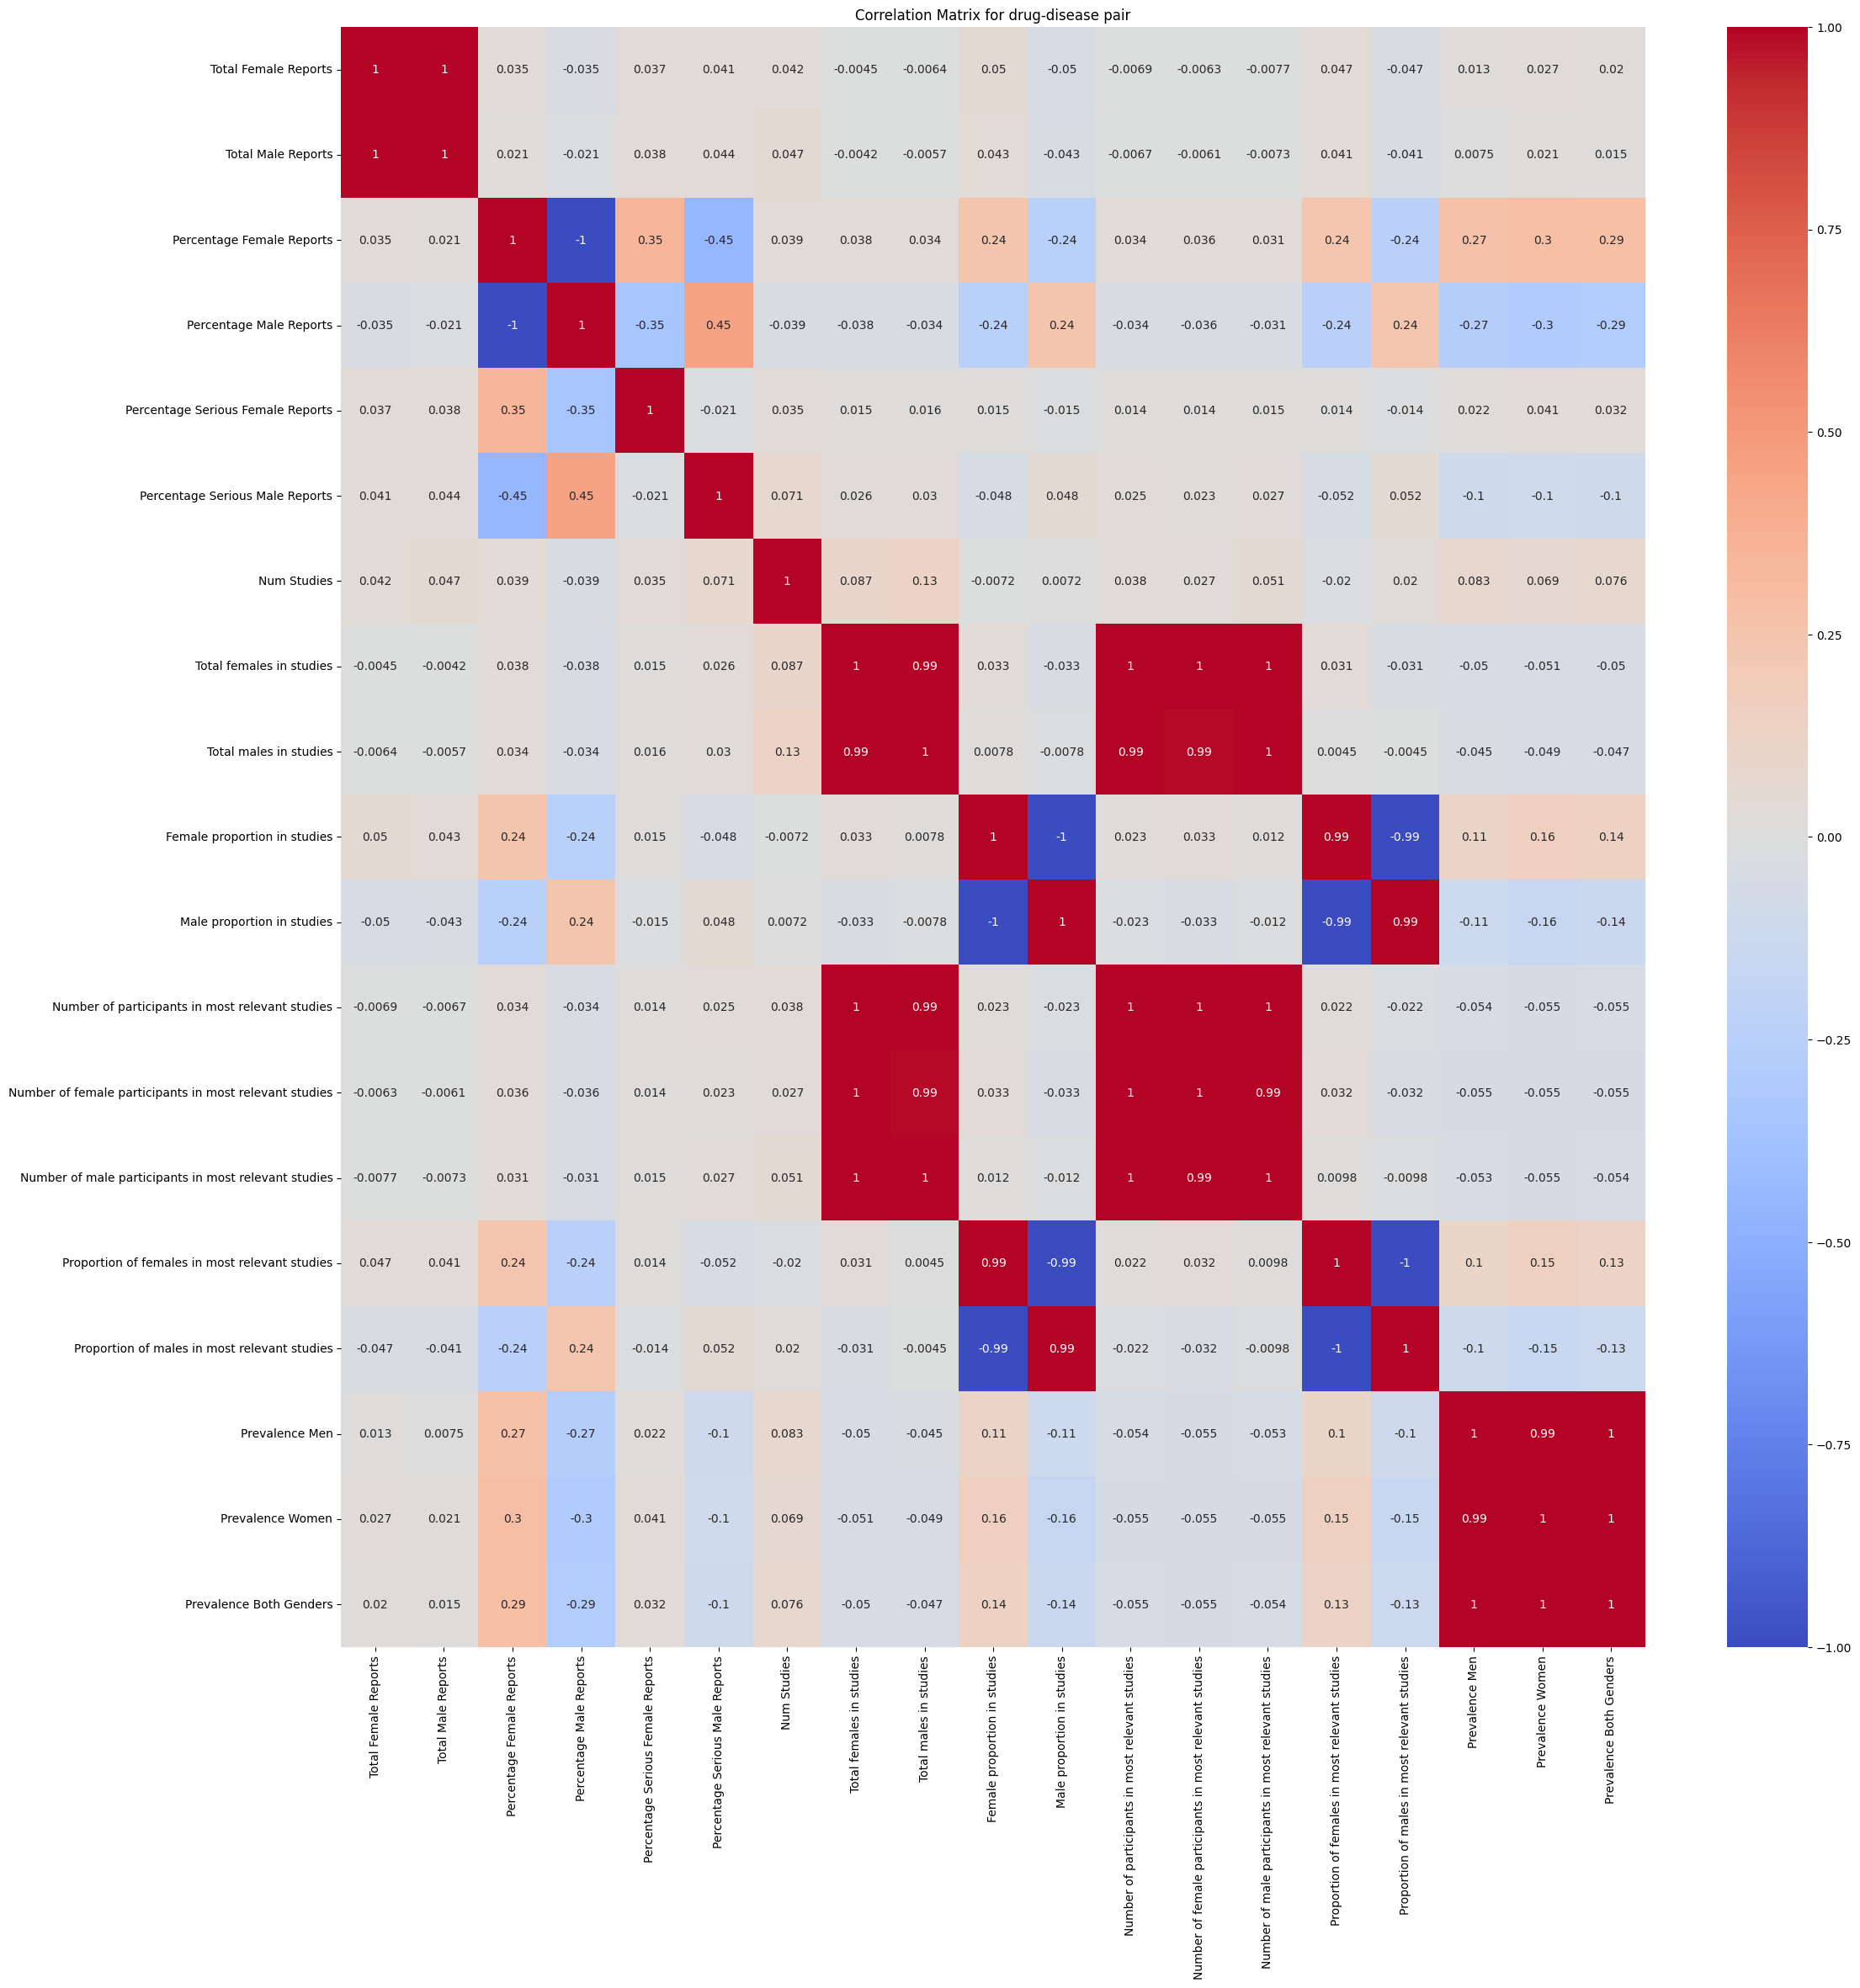

In [15]:
# Correlation matrix
matrix = data_df.drop(columns=['Indication', 'Drug', 'NCT Numbers', 'Most relevant studies', 'Top 5 Side Effects Female', 'Top 5 Side Effects Male'])
corr_matrix = matrix.corr()
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for drug-disease pair')
plt.show()